In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
cd ml-100k

C:\Users\tyadav\Downloads\ml-100k


In [4]:
# Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

In [5]:
# Reading rating files:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings= pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

In [6]:
# Reading Item file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

In [7]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
ratings_train.shape, ratings_test.shape

((90570, 4), (9430, 4))

In [8]:
class MF():
    # Initializing the user-movie rating matrix,
    # number of latent features, alpha and beta
    
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        
    # Initializing user-features and movie-feature matrix
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size = (self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size = (self.num_items, self.K))
        
        # Initializing the bias terms
        
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        
        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
            ]
        # Stochastic gradient descent for given number of iterations
        
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" %(i+1, mse))
            
        return training_process
    
    # Computing total mean squared error
    
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)
    
    # Stochastic Gradient Descent to get optimized P and Q matrix
    
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r-prediction)
            
            self.b_u[i] += self.alpha * (e-self.beta*self.b_u[i])
            self.b_i[j] += self.alpha * (e-self.beta*self.b_i[i])
            
            self.P[i,:] += self.alpha*(e*self.Q[j,:] - self.beta*self.P[i,:])
            self.Q[j,:] += self.alpha*(e*self.P[i,:] - self.beta*self.Q[j,:])
            
            
    # Rating for user i and movie j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis,:] + mf.P.dot(mf.Q.T)

In [9]:
R= np.array(ratings_train.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))

In [10]:
def evaluator(predicted_value, actual_value):
    if np.ceil(predicted_value) - predicted_value <= 0.3 or predicted_value - np.floor(predicted_value) <= 0.3:
        return np.round(predicted_value)
    elif np.ceil(predicted_value)-predicted_value > 0.3 and predicted_value - np.floor(predicted_value) > 0.3:
        if np.ceil(predicted_value) == actual_value:
            return np.ceil(predicted_value)
        elif np.floor(predicted_value) == actual_value:
            return np.floor(predicted_value)
        else:
            return np.round(predicted_value)

In [11]:
pred = []
acc = []
for k in [1, 2, 3, 4, 5]:
    print("For k = %d" %(k))
    mf = MF(R, K=k, alpha=0.0125, beta=0.01, iterations=100)
    training_process = mf.train()
    print()
    print("P x Q:")
    print(mf.full_matrix())
    print()
    op = mf.full_matrix()
    for i in range(len(ratings_test)):
        pred.append(op[ratings_test.user_id[i]-1, ratings_test.movie_id[i]-1])
        
    for i in range(len(pred)):
        if pred[i] > 5:
            pred[i] = 5.0
        if pred[i] < 1:
            pred[i] = 1.0
    y = []
    for i in range(len(pred)):
        y.append(evaluator(pred[i], ratings_test.iloc[i]["rating"]))
        
    acc.append(y == ratings_test.rating)
    pred = []

For k = 1
Iteration: 20 ; error = 271.5981
Iteration: 40 ; error = 268.5409
Iteration: 60 ; error = 263.8990
Iteration: 80 ; error = 261.1783
Iteration: 100 ; error = 260.1431

P x Q:
[[3.86602018 3.02335756 3.09568616 ... 1.71513206 3.80803318 3.11770849]
 [3.99148096 3.21564612 3.1857068  ... 2.22883163 3.75616787 3.3696125 ]
 [3.37232201 2.49579231 2.6199484  ... 1.02468165 3.40420061 2.55993123]
 ...
 [4.13780657 3.3658483  3.32997659 ... 2.39767831 3.8922071  3.52327287]
 [4.52599738 3.93627116 3.621526   ... 3.84455393 3.79684899 4.25626057]
 [3.94457337 3.16587763 3.14031641 ... 2.16530354 3.71685161 3.31729188]]

For k = 2
Iteration: 20 ; error = 260.1744
Iteration: 40 ; error = 253.9963
Iteration: 60 ; error = 252.0258
Iteration: 80 ; error = 251.0799
Iteration: 100 ; error = 250.5855

P x Q:
[[3.83400778 3.10933984 3.20909865 ... 2.81710104 3.35789832 3.2918465 ]
 [3.81672793 2.89912799 2.04294837 ... 3.02186831 3.05865028 3.46834661]
 [3.23668818 2.67789314 3.18075416 ... 1.

In [12]:
accuracy = []
for i in range(len(acc)):
    accuracy.append(np.mean(acc[i]))

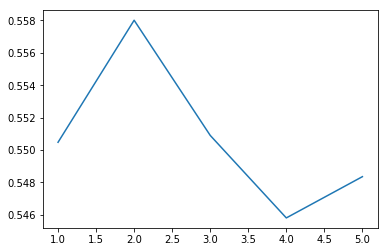

In [13]:
plt.plot([1,2,3,4,5], accuracy)

In [23]:
# for i in range(len(pred)):
#     if pred[i] > 5:
#         pred[i] = 5.0
#     if pred[i] < 1:
#         pred[i] = 1.0

In [1]:
# def evaluator(predicted_value, actual_value):
#     if np.ceil(predicted_value) - predicted_value <= 0.3 or predicted_value - np.floor(predicted_value) <= 0.3:
#         return np.round(predicted_value)
#     elif np.ceil(predicted_value)-predicted_value > 0.3 and predicted_value - np.floor(predicted_value) > 0.3:
#         if np.ceil(predicted_value) == actual_value:
#             return np.ceil(predicted_value)
#         elif np.floor(predicted_value) == actual_value:
#             return np.floor(predicted_value)
#         else:
#             return np.round(predicted_value)

In [25]:
# y = []
# for i in range(len(pred)):
#     y.append(evaluator(pred[i], ratings_test.iloc[i]["rating"]))


In [26]:
# np.mean(y == ratings_test.rating)

0.5199363732767762

In [ ]:
# for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]:
#     print("For k = %d" %(k))
#     mf = MF(R, K=k, alpha=0.0125, beta=0.01, iterations=100)
#     training_process = mf.train()
#     print()
#     print("P x Q:")
#     print(mf.full_matrix())
#     print()
#     op = mf.full_matrix()
#     for i in range(len(ratings_test)):
#         pred.append(op[ratings_test.user_id[i]-1, ratings_test.movie_id[i]-1])
#     predict = np.array(pred)
#     y = []
#     for i in range(len(predict)):
#         y.append(evaluator(pred[i], ratings_test.iloc[i]["rating"]))
#     acc.append(y == ratings_test.rating))
#     pred = []